# Network model for Papers Past

Here I'm going to explore the word vectors using some graph theoretic modelling.

In [7]:
import json
import fasttext
import numpy as np
import pandas as pd
import igraph as ig
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.linalg import norm
from utils import multicore_apply

In [8]:
model_data = pd.read_csv('../data/model_data.csv')
model = fasttext.load_model("../data/fasttext.bin")

In [9]:
model_data

,word,count
0,te,763785
1,e,388836
2,nga,356423
3,o,355744
4,ki,259854
...,...,...
7383,mahii,30
7384,raoana,30
7385,tangira,30
7386,rakaipaka,30


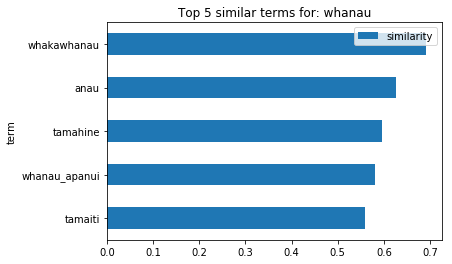

In [10]:
k = 5

def get_similar_terms(term, k = 15):
    return (pd.DataFrame(
        model.get_nearest_neighbors(term, k=k), 
        columns = ['similarity', 'term'])
       .sort_values('similarity')
    )

term = 'whanau'
similar_terms = get_similar_terms(term, k)
similar_terms.plot(kind = 'barh', x = 'term', y = 'similarity', title = 'Top {} similar terms for: {}'.format(k, term))

In [11]:
model_data['word_vector'] = model_data.word.apply(lambda x: model.get_word_vector(x)).apply(lambda x: x / norm(x))

In [12]:
word_vectors = np.vstack(model_data.word_vector)
word_vectors = np.dot(word_vectors, word_vectors.transpose())

''

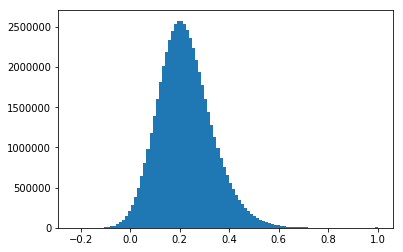

In [13]:
plt.hist(word_vectors.flatten(), bins = 100)
''

In [32]:
[(model_data.word[x], model_data.word[y], word_vectors[x,y]) for x,y in zip(*np.where(word_vectors < -0.2))]

[('timi_kara', 'takiwha', -0.21328412),
 ('pereti', 'arohatia', -0.20074564),
 ('riu', 'mahita', -0.20103075),
 ('peni', 'ehinu', -0.20299464),
 ('mahita', 'riu', -0.20103075),
 ('putiputi', 'wakatika', -0.2274998),
 ('kiau', 'ahanoa', -0.20849283),
 ('tehee', 'puru_ripene', -0.2016142),
 ('puru_ripene', 'tehee', -0.2016142),
 ('arohatia', 'pereti', -0.20074564),
 ('kouto', 'rumu', -0.21921934),
 ('rumu', 'kouto', -0.21921934),
 ('ahanoa', 'kiau', -0.20849283),
 ('paewai', 'whakawhairawa', -0.21139239),
 ('paewai', 'whairawa', -0.22897212),
 ('paewai', 'whangai_hipi', -0.20868336),
 ('whakawhairawa', 'paewai', -0.21139239),
 ('wakatika', 'putiputi', -0.2274998),
 ('whairawa', 'paewai', -0.22897212),
 ('ehinu', 'peni', -0.20299464),
 ('whangai_hipi', 'paewai', -0.20868336),
 ('takiwha', 'timi_kara', -0.21328412)]

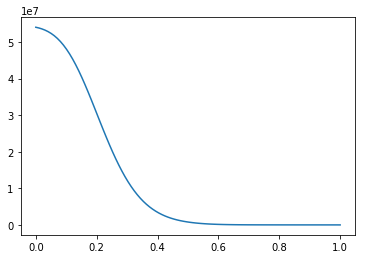

In [8]:
plt.plot(np.linspace(0, 1, 100), [np.sum(word_vectors > x) for x in np.linspace(0, 1, 100)])

In [9]:
threshold = 0.55

In [10]:
adjacency = np.copy(word_vectors)
adjacency[adjacency < threshold] = 0

In [11]:
model_data['neighbours'] = np.sum(adjacency > 0, axis = 1)

In [12]:
model_data.sort_values('neighbours', ascending = False)

,word,count,word_vector,neighbours
6839,patuawa,33,"[-0.19998589, 0.14850602, 0.030414287, -0.0049...",697
5151,manuera,50,"[-0.16191539, 0.05605171, -0.0018674473, -0.00...",689
6576,menehira,35,"[-0.12593593, 0.09738433, -0.11902487, 0.07379...",652
7122,rangiahua,31,"[-0.11843723, 0.16338772, 0.07366886, -0.06037...",584
6668,kuri_rangiahua,34,"[-0.16005608, 0.02785649, 0.10985294, -0.03306...",576
...,...,...,...,...
2273,iha,165,"[0.06563969, -0.035491847, -0.15909977, -0.063...",1
1880,uie,222,"[-0.093235314, 0.11627207, -0.019732289, 0.044...",1
2392,itewa,153,"[-0.056500304, -0.04929303, 0.0040264586, 0.02...",1
1362,pura,347,"[-0.10969708, 0.21585472, -0.11019635, 0.11989...",1


In [13]:
G = ig.Graph()

In [14]:
G.add_vertices(model_data.word)

In [15]:
edges = [(model_data.word[x], model_data.word[y]) for x,y in zip(*np.where(adjacency != 0)) if x < y]
weights = [adjacency[x,y] for x,y in zip(*np.where(adjacency != 0)) if x < y]

In [16]:
G.add_edges(edges)

In [17]:
G.es['weight'] = [1 for e in edges] # weights

In [18]:
G.vs['word_count'] = model_data['count']

In [19]:
%%time
G.diameter()

CPU times: user 3.47 s, sys: 0 ns, total: 3.47 s
Wall time: 3.46 s


9

In [20]:
density = G.density()
print("Network density:", density)

Network density: 0.006297993907704084


In [21]:
[[model_data.word[y] for y in x] for x in G.get_shortest_paths('whakaminenga', 'mohi_tawhai')]

[['whakaminenga', 'rangatira', 'ngapuhi', 'mohi_tawhai']]

In [22]:
[[model_data.word[y] for y in x] for x in G.get_shortest_paths('mahunga', 'wae_wae')]

[['mahunga', 'whiore', 'wae_wae']]

In [23]:
G.is_connected()

False

In [24]:
triadic_closure = G.transitivity_undirected()
print("Triadic closure:", triadic_closure)

Triadic closure: 0.3870609302868561


In [ ]:
%%time
# calculate dendrogram
dendrogram = G.community_edge_betweenness(directed = False)

In [ ]:
%%time
# convert it into a flat clustering
clusters = dendrogram.as_clustering()

In [ ]:
%%time
# get the membership vector
membership = clusters.membership